In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import Aer
from qiskit.compiler import transpile, assemble
from qiskit.visualization import *
from qiskit.circuit.library import QFT
from numpy import pi
from qiskit.quantum_info import Statevector
from matplotlib import pyplot as plt
import numpy as np


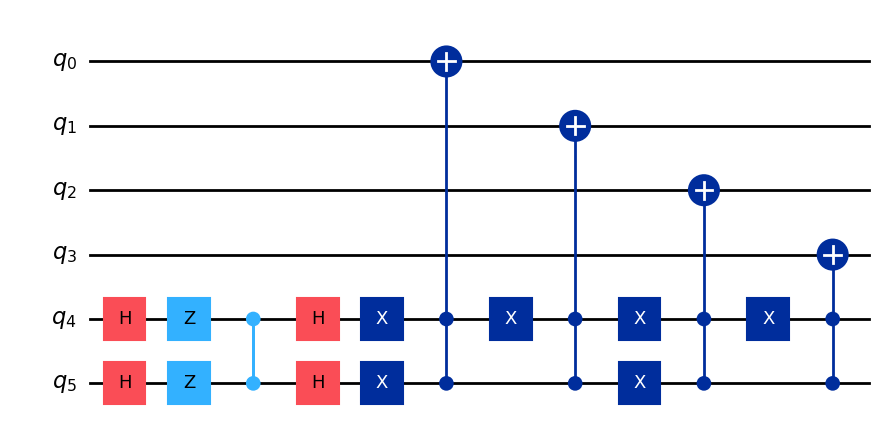

In [3]:
one_step_circuit = QuantumCircuit(6, name=' ONE STEP') 
# Coin operator
one_step_circuit.h([4,5])
one_step_circuit.z([4,5])
one_step_circuit.cz(4,5)
one_step_circuit.h([4,5])

# Shift operator function for 4d-hypercube
def shift_operator(circuit):
    for i in range(0,4):
        circuit.x(4)
        if i%2==0:
            circuit.x(5)
        circuit.ccx(4,5,i)

shift_operator(one_step_circuit)

one_step_gate = one_step_circuit.to_instruction() 
one_step_circuit.draw("mpl")

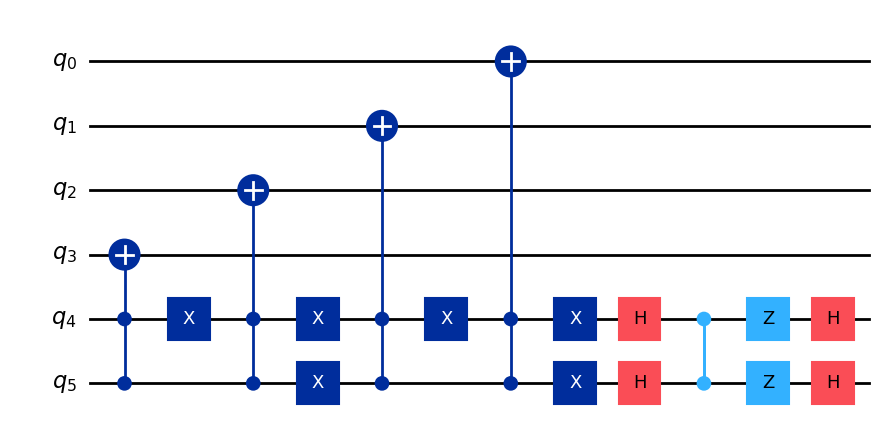

In [4]:
one_step_circuit.inverse().draw("mpl")

In [5]:
inv_cont_one_step = one_step_circuit.inverse().control()
inv_cont_one_step_gate = inv_cont_one_step.to_instruction()
cont_one_step = one_step_circuit.control()
cont_one_step_gate = cont_one_step.to_instruction()

inv_qft_gate = QFT(4, inverse=True).to_instruction()  
qft_gate = QFT(4, inverse=False).to_instruction()

QFT(4, inverse=True).decompose()

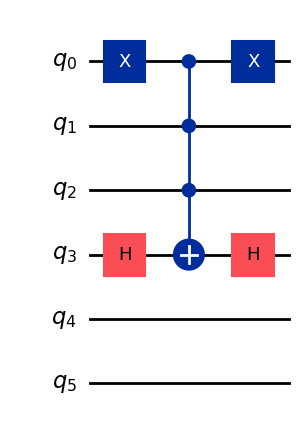

In [6]:
phase_circuit =  QuantumCircuit(6, name=' phase oracle ')
# Mark 1011
# phase_circuit.x(1)
# phase_circuit.h(0)
# phase_circuit.mcx([0,1,2], 3)
# phase_circuit.h(1)
# phase_circuit.h(2)
# phase_circuit.h(3)
# phase_circuit.x(1)
# Mark 1111
phase_circuit.x(0)
phase_circuit.h(3)
phase_circuit.mcx([0,1,2],3)
phase_circuit.h(3)
phase_circuit.x(0)
phase_oracle_gate = phase_circuit.to_instruction()
# Phase oracle circuit
phase_oracle_circuit =  QuantumCircuit(11, name=' PHASE ORACLE CIRCUIT ')
phase_oracle_circuit.append(phase_oracle_gate, [4,5,6,7,8,9])
phase_circuit.draw("mpl")

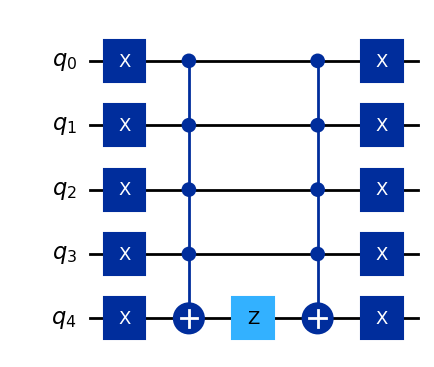

In [7]:
# Mark q_4 if the other qubits are non-zero 
mark_auxiliary_circuit = QuantumCircuit(5, name=' mark auxiliary ')
mark_auxiliary_circuit.x([0,1,2,3,4])
mark_auxiliary_circuit.mcx([0,1,2,3], 4)
mark_auxiliary_circuit.z(4)
mark_auxiliary_circuit.mcx([0,1,2,3], 4)
mark_auxiliary_circuit.x([0,1,2,3,4])

mark_auxiliary_gate = mark_auxiliary_circuit.to_instruction()
mark_auxiliary_circuit.draw("mpl")

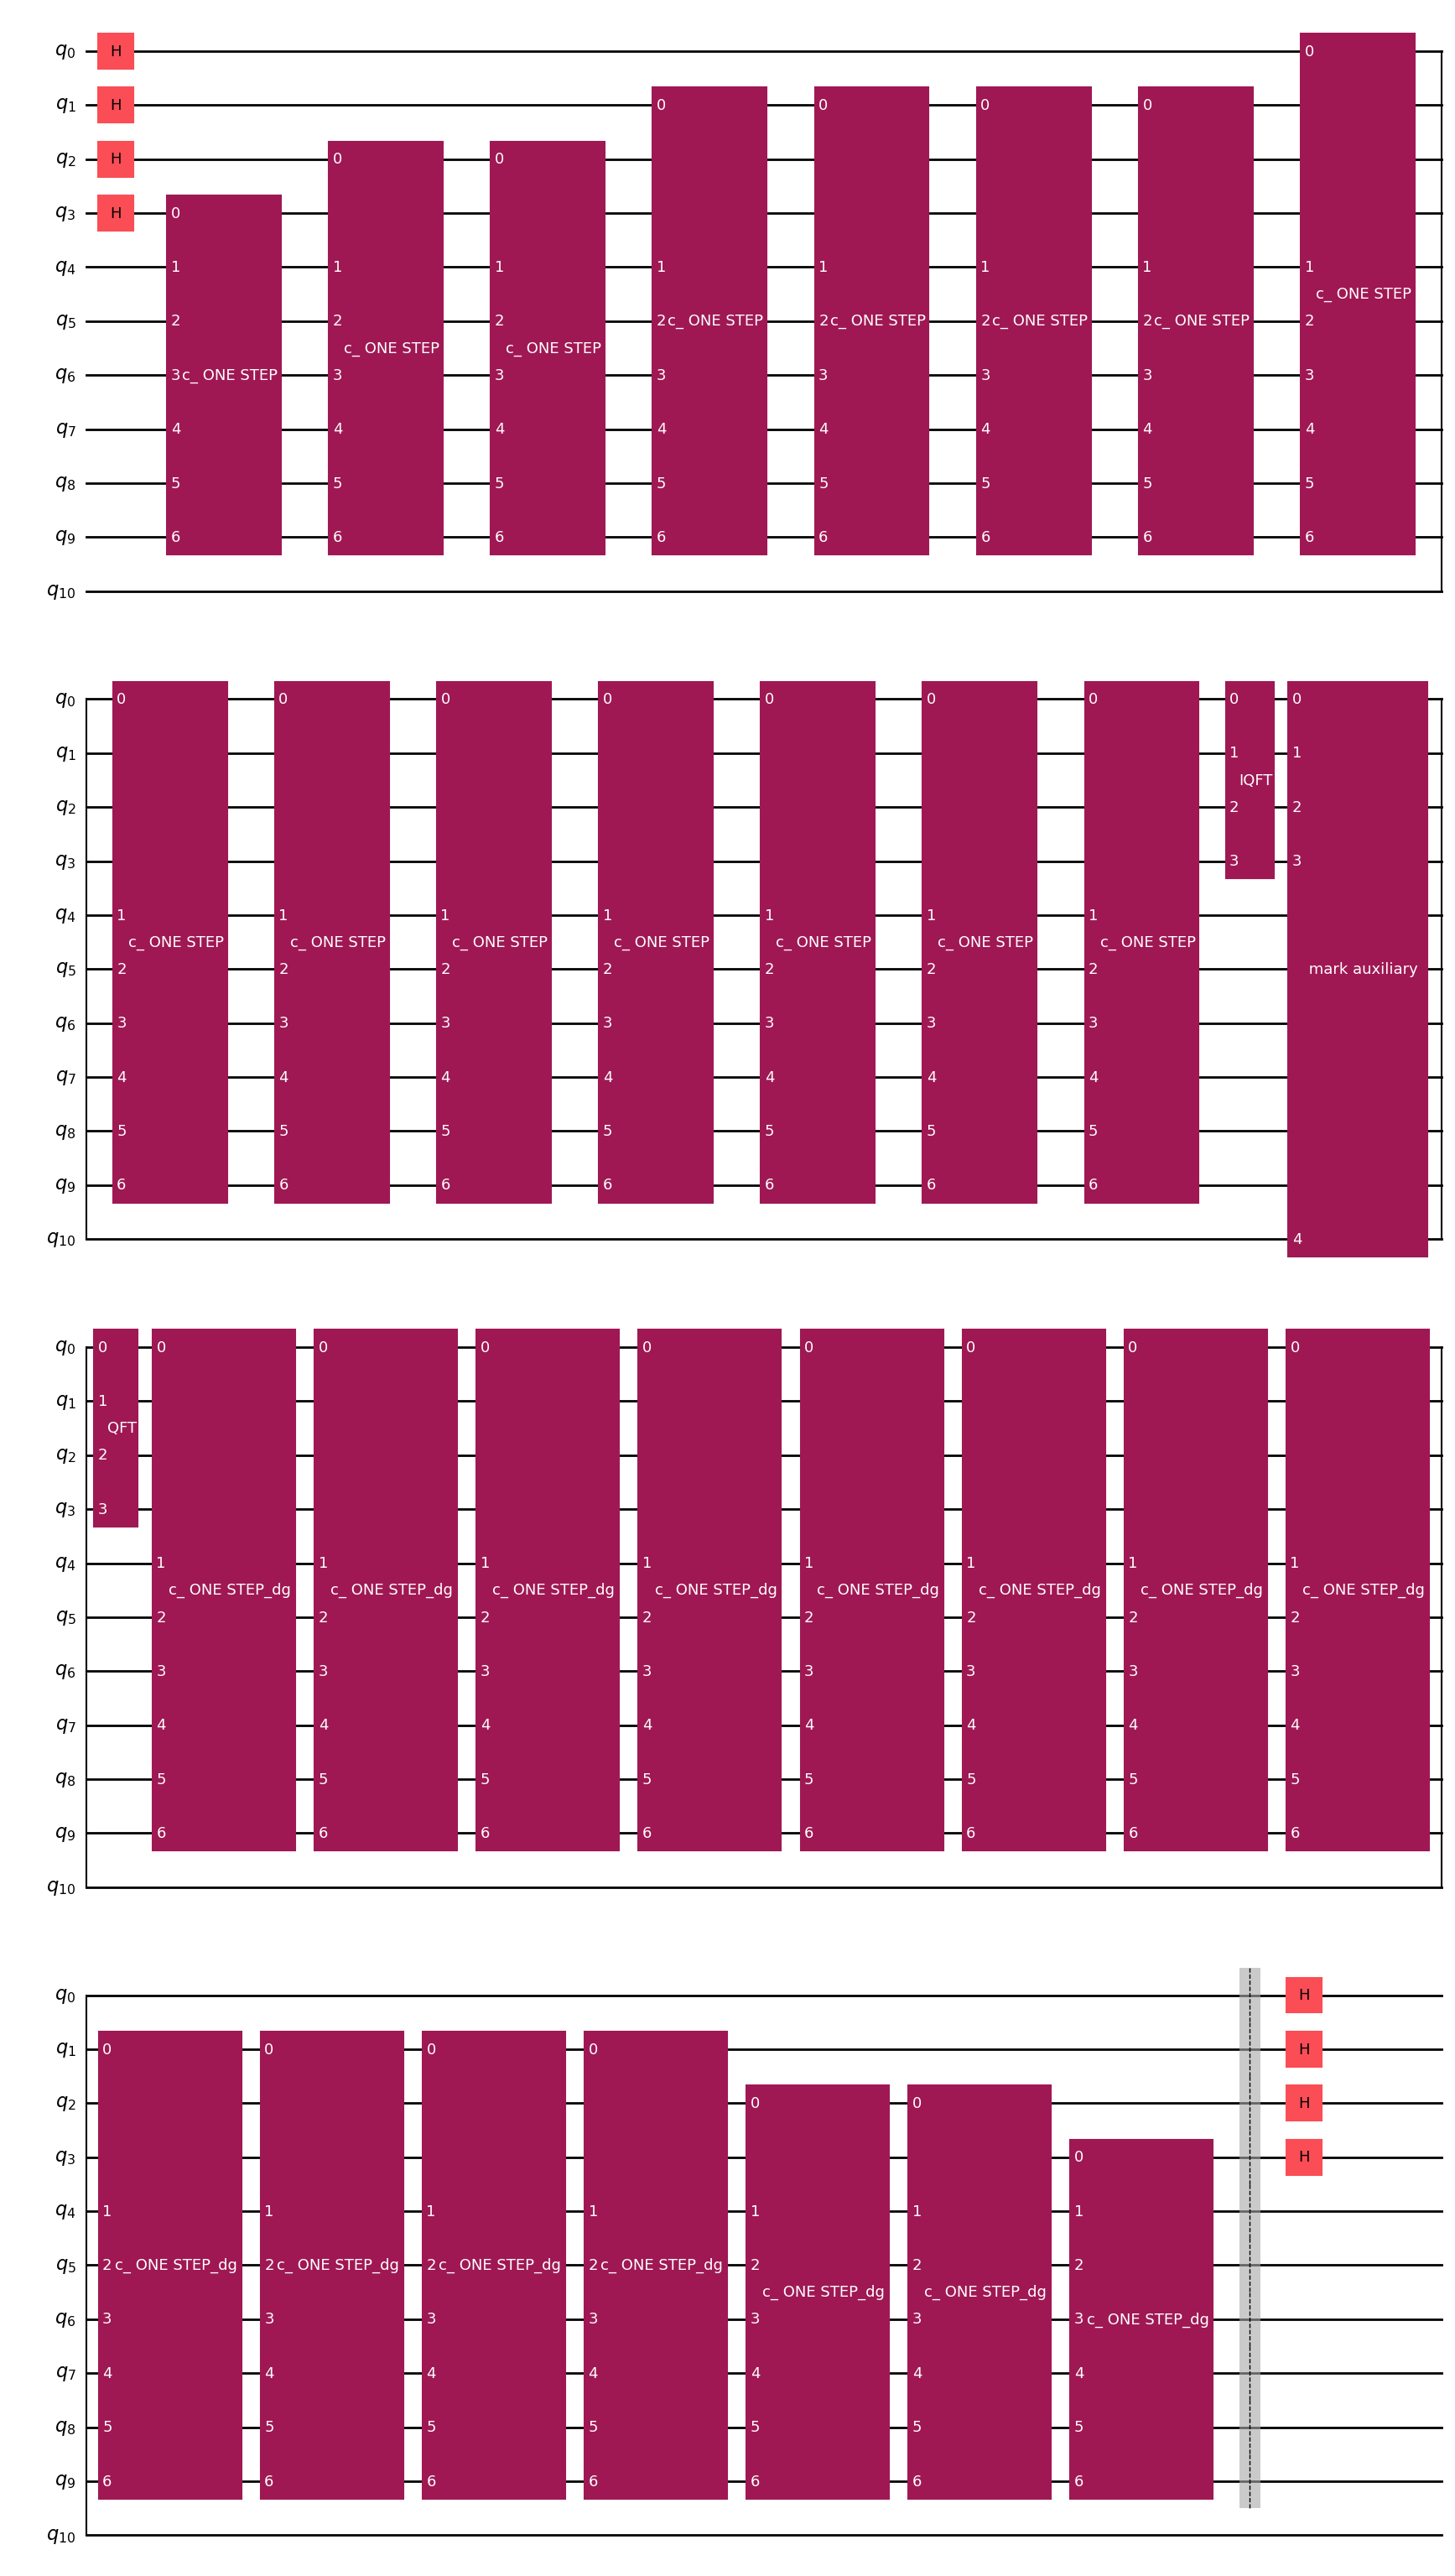

In [8]:
# Phase estimation
phase_estimation_circuit = QuantumCircuit(11, name=' phase estimation ')
phase_estimation_circuit.h([0,1,2,3])
for i in range(0,4):
    stop = 2**i
    for j in range(0,stop):
        phase_estimation_circuit.append(cont_one_step, [3-i,4,5,6,7,8,9])

# Inverse fourier transform
phase_estimation_circuit.append(inv_qft_gate, [0,1,2,3])

# Mark all angles theta that are not 0 with an auxiliary qubit
phase_estimation_circuit.append(mark_auxiliary_gate, [0,1,2,3,10])

# Reverse phase estimation
phase_estimation_circuit.append(qft_gate, [0,1,2,3])   

for i in range(3,-1,-1):
    stop = 2**i
    for j in range(0,stop):
        phase_estimation_circuit.append(inv_cont_one_step, [3-i,4,5,6,7,8,9])
phase_estimation_circuit.barrier(range(0,10))
phase_estimation_circuit.h([0,1,2,3])

# Make phase estimation gate
phase_estimation_gate = phase_estimation_circuit.to_instruction()
phase_estimation_circuit.draw(output='mpl')

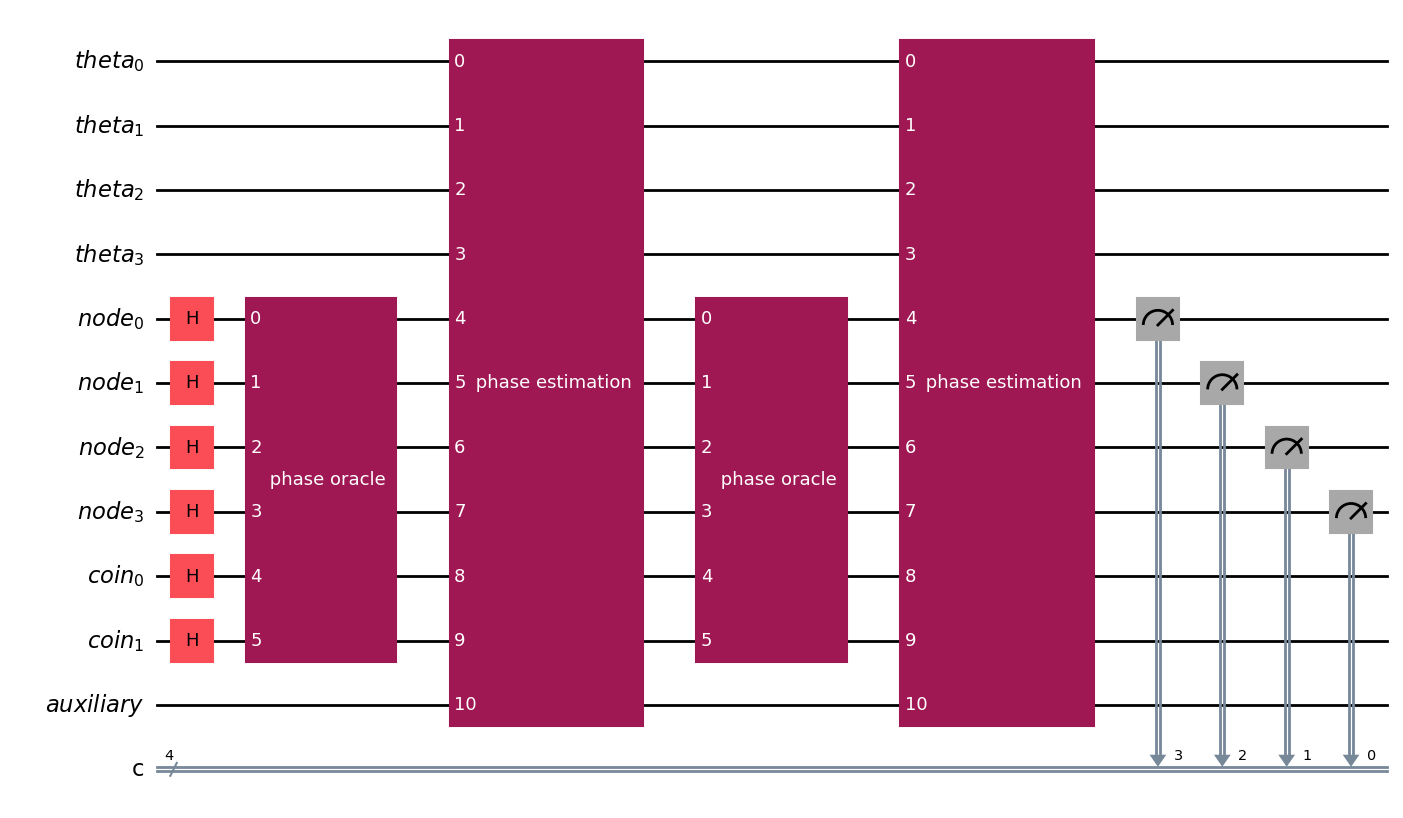

In [9]:
# Implementation of the full quantum walk search algorithm
theta_q = QuantumRegister(4, 'theta')
node_q = QuantumRegister(4, 'node')
coin_q = QuantumRegister(2, 'coin')
auxiliary_q = QuantumRegister(1, 'auxiliary')
creg_c2 = ClassicalRegister(4, 'c')
circuit = QuantumCircuit(theta_q, node_q, coin_q, auxiliary_q, creg_c2)
# Apply Hadamard gates to the qubits that represent the nodes and the coin
circuit.h([4,5,6,7,8,9])
# circuit.h([4,5,6,7])
iterations = 2

for i in range(0,iterations):
    circuit.append(phase_oracle_gate, [4,5,6,7,8,9])
    circuit.append(phase_estimation_gate, [0,1,2,3,4,5,6,7,8,9,10])

circuit.measure(node_q[0], creg_c2[3])
circuit.measure(node_q[1], creg_c2[2])
circuit.measure(node_q[2], creg_c2[1])
circuit.measure(node_q[3], creg_c2[0])
circuit.draw(output='mpl')

C:\Users\26550\AppData\Local\Temp\ipykernel_13364\3574652678.py:4: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = simulator.run(qobj).result()


Counts: {'0111': 928, '1100': 9, '1011': 7, '1000': 7, '0000': 9, '0101': 10, '1110': 4, '0110': 9, '0010': 7, '0011': 6, '1010': 4, '0001': 5, '0100': 4, '1001': 6, '1111': 4, '1101': 5}


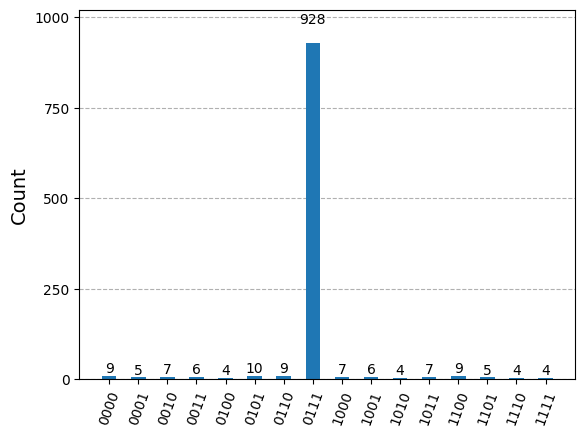

In [10]:
simulator = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(circuit, simulator)
qobj = assemble(compiled_circuit)
result = simulator.run(qobj).result()
counts = result.get_counts(circuit)
print("Counts:", counts)

# Plot the result
plot_histogram(counts)

In [11]:
# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# import numpy as np
# from qiskit.circuit.library import IQP
# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# from qiskit.quantum_info import random_hermitian
# from qiskit_ibm_runtime import QiskitRuntimeService
 
# service = QiskitRuntimeService()
# backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)


# pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
# isa_circuit = pm.run(circuit)



In [12]:
# from qiskit_ibm_runtime import QiskitRuntimeService

# service = QiskitRuntimeService(channel="ibm_quantum", # ibm_cloud 
#                                token = 'ff4ebb3d732e8c0e11b5a77b7ccd6e2996f9c39bcda169d8e90a16b335528d33436e36f6f1ae07dbd353102bac737f6e049c76feae577176178d1c03fa034812')

# QiskitRuntimeService.save_account(channel='ibm_quantum',
#                                   token = 'ff4ebb3d732e8c0e11b5a77b7ccd6e2996f9c39bcda169d8e90a16b335528d33436e36f6f1ae07dbd353102bac737f6e049c76feae577176178d1c03fa034812')

# backend = service.backend(name = "ibm_brisbane")

# backend.num_qubits


In [13]:
# from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

# service = QiskitRuntimeService()
# backend = service.backend("ibm_sherbrooke")
# job = Sampler(backend).run(isa_circuit)
# print(f"job id: {job.job_id()}")
# result = job.result()
# print(result)
